In [30]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import matplotlib

In [32]:
import os
import logging
import argparse
import glob
import json
from collections import Counter

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot import label_metadata
from zoobot.estimators import losses


In [33]:
os.chdir('/home/walml/repos/zoobot')

In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [35]:
catalog_loc = 'data/gz2/gz2_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/galaxy_zoo/gz2' + x[32:])
catalog['id_str'] = catalog['dr7objid'].apply(lambda x: 'dr7objid_' + str(x))

In [36]:
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

label_cols = label_metadata.gz2_partial_label_cols
questions = label_metadata.gz2_partial_questions

# state_loc = 'results/temp/gz2_all_q_warm_active/iteration_0/state.pickle'
# label_cols = label_metadata.gz2_label_cols
# questions = label_metadata.gz2_questions

version = 'gz2'
schema = losses.Schema(label_cols, questions, version=version)

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after smooth-or-featured_featured-or-disk, index 1: (2, 3), bar, indices 4 to 5, asked after smooth-or-featured_featured-or-disk, index 1: (4, 5), bulge-size, indices 6 to 9, asked after smooth-or-featured_featured-or-disk, index 1: (6, 9)}


In [37]:
concentration_cols = [col + '_concentration' for col in label_cols]
concentration_mean_cols = [col + '_concentration_mean' for col in label_cols]

# for it in it_list:
#     for col in concentration_cols:
#         it[col] = it[col].apply(lambda x: np.array(json.loads(x)))

In [38]:
m = 0

active_locs = [f'temp/gz2_1q_conc_active_it2_m{n}.csv' for n in range(3)]
baseline_locs = [f'temp/gz2_1q_conc_baseline_it2_m{n}.csv' for n in range(3)]

active_dfs = [pd.read_csv(loc) for loc in active_locs]
baseline_dfs = [pd.read_csv(loc) for loc in baseline_locs]


In [39]:
from zoobot.estimators import dirichlet_stats

In [40]:
active_concentrations = [dirichlet_stats.load_all_concentrations(df, concentration_cols) for df in active_dfs]
baseline_concentrations = [dirichlet_stats.load_all_concentrations(df, concentration_cols) for df in baseline_dfs]

In [41]:
answer_cols = [a.text for a in schema.answers]
labels = active_dfs[0][answer_cols].values  # same for all

In [42]:
labels.shape

(15000, 10)

In [43]:
active_concentrations[0].shape

(15000, 10, 2)

In [44]:
active_concentrations_combined = np.concatenate(active_concentrations, axis=-1)
active_concentrations_combined.shape

(15000, 10, 6)

In [45]:
single_loss = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentrations[0], schema.question_index_groups)
active_losses = dirichlet_stats.dirichlet_mixture_loss(labels, active_concentrations_combined, schema.question_index_groups)

In [46]:
list(zip(questions, single_loss.mean(axis=0)))

[('smooth-or-featured', 2.39677),
 ('has-spiral-arms', 1.2300723),
 ('bar', 1.0991116),
 ('bulge-size', 3.0051959)]

In [47]:
list(zip(questions, active_losses.mean(axis=0)))

[('smooth-or-featured', 2.3773024),
 ('has-spiral-arms', 1.2183918),
 ('bar', 1.0819622),
 ('bulge-size', 2.983161)]

In [48]:
baseline_concentrations_combined = np.concatenate(baseline_concentrations, axis=-1)
baseline_losses = dirichlet_stats.dirichlet_mixture_loss(labels, baseline_concentrations_combined, schema.question_index_groups)
list(zip(questions, baseline_losses.mean(axis=0)))

[('smooth-or-featured', 2.3857813),
 ('has-spiral-arms', 1.2270054),
 ('bar', 1.088693),
 ('bulge-size', 2.9784007)]

In [49]:
assert len(active_losses) == len(baseline_losses)

In [50]:
active_like = np.exp(-active_losses)  # inverse of neg log likelihood = 
baseline_like = np.exp(-baseline_losses)

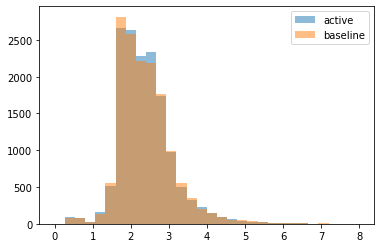

In [51]:
plt.hist(active_losses[:, 0], bins=30, alpha=.5, range=(0., 8.), label='active')
plt.hist(baseline_losses[:, 0], bins=30, alpha=.5, range=(0., 8.), label='baseline')
plt.legend()

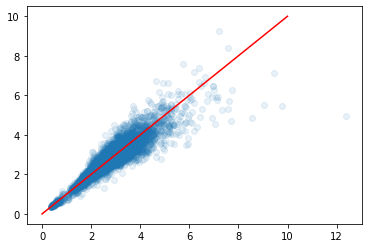

In [52]:
plt.scatter(baseline_losses[:, 0], active_losses[:, 0], alpha=.1)
plt.plot([0., 10], [0., 10.], color='r')

In [53]:
baseline_losses.shape

(15000, 4)

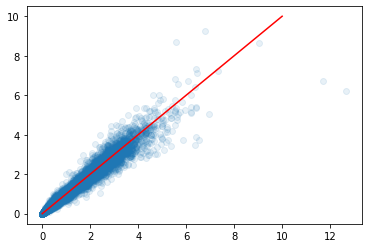

In [54]:
question_n = 1
plt.scatter(baseline_losses[:, question_n], active_losses[:, question_n], alpha=.1)
plt.plot([0., 10], [0., 10.], color='r')

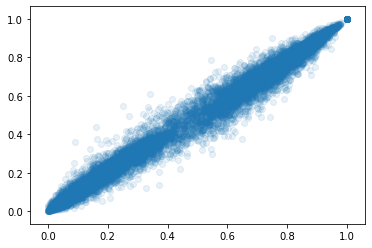

In [55]:
question_n = 1
plt.scatter(baseline_like[:, question_n], active_like[:, question_n], alpha=.1)
# plt.plot([0., 10], [0., 10.], color='r')

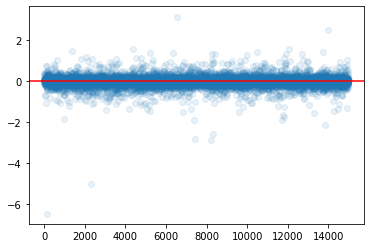

In [56]:
question_n = 1
plt.scatter(np.arange(len(baseline_losses)), active_losses[:, question_n] - baseline_losses[:, question_n], alpha=.1)
plt.axhline(0., color='r')

(-1, 1)

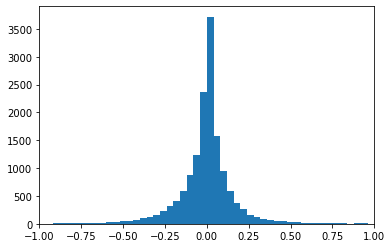

In [57]:
_ = plt.hist(active_losses[:, question_n] - baseline_losses[:, question_n], range=(-1, 1), bins=50)
plt.xlim(-1, 1)

In [58]:
for question_n in range(4):
    print((active_losses[:, question_n] - baseline_losses[:, question_n]).mean())

-0.0084694065
-0.008617325
-0.0067302836
0.0047541964


In [59]:
delta_loss = active_losses[:, question_n] - baseline_losses[:, question_n]
for window in [0, 2, 5, 10, 20, 30, 40]:
    delta_loss_clipped = np.clip(delta_loss, np.percentile(delta_loss, window), np.percentile(delta_loss, 100 - window))
    print(window, delta_loss_clipped.mean()) 
# negative delta loss = baseline bigger loss than active = active better, and vica versa
# possibly active learning helps more with the hardest galaxies, in exchange for some of the easiest galaxies?
# no, I'm being silly, it's DELTA loss...

0 0.0047541964
2 0.0038513471
5 0.0023385151
10 0.0010176967
20 -0.00095614203
30 0.00052202464
40 0.0030043619


In [60]:

for window in [0, 2, 5, 10, 20, 30, 40]:
    delta_loss_clipped = np.clip(delta_loss, np.percentile(delta_loss, window), np.percentile(delta_loss, 100 - window))
    print(window, delta_loss_clipped.mean()) 
# negative delta loss = baseline bigger loss than active = active better, and vica versa
# possibly active learning helps more with the hardest galaxies, in exchange for some of the easiest galaxies?
# no, I'm being silly, it's DELTA loss...

0 0.0047541964
2 0.0038513471
5 0.0023385151
10 0.0010176967
20 -0.00095614203
30 0.00052202464
40 0.0030043619


In [61]:
question_n = 1

In [62]:
results = []
mean_loss = (active_losses[:, question_n] + baseline_losses[:, question_n]) / 2
delta_loss = active_losses[:, question_n] - baseline_losses[:, question_n]
bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    print(min_pc, max_pc)
    min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
    selection = (mean_loss < max_val) & (mean_loss >= min_val)
    
    valid_delta = delta_loss[selection]
    print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))


0 10
0 10 1500 0.003293114 4.8
10 20
10 20 1500 0.01442133 4.8
20 30
20 30 1500 0.02279445 3.9
30 40
30 40 1500 0.031048523 4.6
40 50
40 50 1500 0.017159037 5.7
50 60
50 60 1500 -0.01770263 5.1
60 70
60 70 1500 -0.032709036 13.4
70 80
70 80 1500 -0.039351374 7.9
80 90
80 90 1500 -0.037752695 10.5
90 100
90 100 1499 -0.043100342 15.7


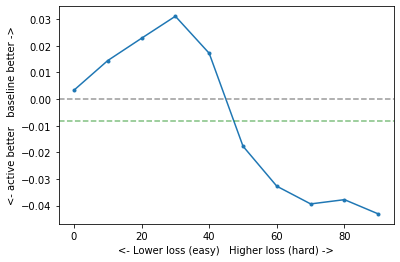

In [63]:
x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower loss (easy)   Higher loss (hard) ->')
plt.ylabel('<- active better   baseline better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

0 5
0 5 750 0.0014413341 11.0
5 10
5 10 750 0.0012394739 15.7
10 15
10 15 750 0.002010742 10.5
15 20
15 20 750 0.005586506 6.6
20 25
20 25 750 0.004560639 8.4
25 30
25 30 750 0.0068277307 5.3
30 35
30 35 750 0.0063153063 16.2
35 40
35 40 750 0.006981823 5.8
40 45
40 45 750 0.007055752 5.1
45 50
45 50 750 0.0049320213 4.4
50 55
50 55 750 0.00016047231 5.5
55 60
55 60 750 -0.01776947 6.7
60 65
60 65 750 -0.021320645 15.3
65 70
65 70 750 -0.016211372 4.6
70 75
70 75 750 -0.01878805 4.7
75 80
75 80 750 -0.015744891 8.1
80 85
80 85 750 -0.012846609 4.8
85 90
85 90 750 -0.011044958 5.2
90 95
90 95 750 -0.005857286 4.8
95 100
95 100 49 -0.0026613874 4.1


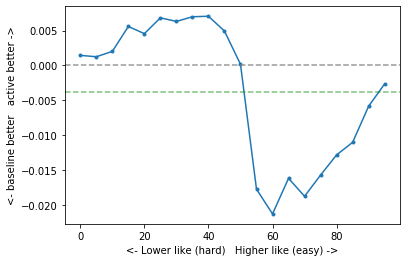

In [66]:
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
bin_width = 5
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    print(min_pc, max_pc)
    min_val, max_val = np.percentile(mean_like, min_pc), np.percentile(mean_like, max_pc)
    selection = (mean_like < max_val) & (mean_like >= min_val)
    
    valid_delta = delta_like[selection]
    print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower like (hard)   Higher like (easy) ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

0.0 2.0
0.0652
2.0 3.0
0.08246666666666666
3.0 4.0
0.09926666666666667
4.0 5.0
0.0916
5.0 7.0
0.14646666666666666
7.0 9.0
0.09253333333333333
9.0 14.0
0.11826666666666667
14.0 21.200000000000728
0.1042
21.200000000000728 33.0
0.0938
33.0 60.0
0.10613333333333333


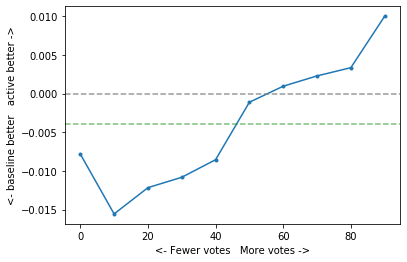

In [67]:
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
votes = active_dfs[0]['smooth-or-featured_featured-or-disk'].values

bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    min_val, max_val = np.percentile(votes, min_pc), np.percentile(votes, max_pc)
    selection = (votes < max_val) & (votes >= min_val)
    print(min_val, max_val)
    print(selection.mean())
    
    valid_delta = delta_like[selection]
#     print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
    results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Fewer votes   More votes ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

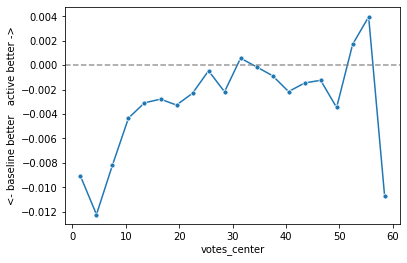

In [68]:
question_n = 2
results = []
mean_like = (active_like[:, question_n] + baseline_like[:, question_n]) / 2
delta_like = active_like[:, question_n] - baseline_like[:, question_n]
votes = active_dfs[0]['smooth-or-featured_featured-or-disk'].values

votes_binned = pd.cut(votes, bins=20)
df = pd.DataFrame(data={'votes_binned': votes_binned, 'delta_like': delta_like})
df['votes_center'] = df['votes_binned'].apply(lambda x: x.left + (x.right - x.left)/2)

grouped = df.groupby('votes_center').agg({'delta_like': 'mean'}).reset_index()

sns.lineplot(data=grouped, x='votes_center', y='delta_like', marker='.', markersize=10)

# bin_width = 10
# for min_pc in np.arange(0, 100, bin_width):
#     max_pc = min_pc + bin_width
#     min_val, max_val = np.percentile(votes, min_pc), np.percentile(votes, max_pc)
#     selection = (votes < max_val) & (votes >= min_val)
#     print(min_val, max_val)
#     print(selection.mean())
    
#     valid_delta = delta_like[selection]
# #     print(min_pc, max_pc, len(valid_delta), valid_delta.mean(), labels[selection][question_n].mean()) 
#     results.append((min_pc, max_pc, valid_delta.mean(), labels[selection][question_n].mean(), labels[selection][question_n]))

# x = [r[0] for r in results]
# y = [r[2] for r in results]
# plt.plot(x, y, marker='.')
# plt.xlabel('<- Fewer votes   More votes ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
# plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

(array([3704., 4333., 1874., 1025.,  737.,  620.,  498.,  496.,  451.,
         525.,  396.,  206.,   92.,   32.,   11.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40., 44., 48.,
        52., 56., 60.]),
 <a list of 15 Patch objects>)

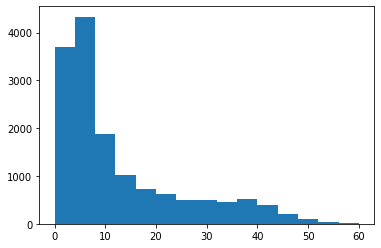

In [69]:
plt.hist(votes, bins=15)

In [186]:
# def pretend_fewer_votes_multiq(labels, question_index_groups):
    
#     q_losses = []
#     for q_n in range(len(question_index_groups)):
#         q_indices = question_index_groups[q_n]
#         q_start = q_indices[0]
#         q_end = q_indices[1]
#         q_loss = pretend_fewer_votes(labels[:, q_start:q_end+1])
#         q_losses.append(q_loss)
    
#     total_loss = np.stack(q_losses, axis=1)
#     return total_loss

def pretend_fewer_votes(votes, new_total=10):
    # votes = (batch, answer) for one q

    n_votes = votes.shape[1]
    new_vote_indices = [np.random.choice(np.arange(n_votes), p=v/v.sum(), size=new_total) for v in votes]
    new_votes = []
    for n in new_vote_indices:
        these_votes = np.zeros(n_votes)
        for i in n:
            these_votes[i] += 1
        new_votes.append(these_votes)
    return np.array(new_votes)

In [211]:
schema.question_index_groups

[(0, 1), (2, 3), (4, 5), (6, 9)]

In [226]:
question_n = 1
question_indices = [2, 4]
question_slice = slice(*question_indices)
batch_slice = labels[:, question_slice].sum(axis=1) >= 10
fewer_votes = pretend_fewer_votes(labels[batch_slice, question_slice])

In [227]:
reduced_labels = labels.copy()
reduced_labels[batch_slice, question_slice] = fewer_votes

In [228]:
reduced_labels[batch_slice, question_slice]

array([[10,  0],
       [ 6,  4],
       [ 8,  2],
       ...,
       [10,  0],
       [10,  0],
       [10,  0]])

In [229]:
active_losses_reduced = dirichlet_stats.dirichlet_mixture_loss(reduced_labels, active_concentrations_combined, schema.question_index_groups)
baseline_losses_reduced = dirichlet_stats.dirichlet_mixture_loss(reduced_labels, baseline_concentrations_combined, schema.question_index_groups)

In [230]:

np.mean(active_losses[:, question_n]), np.mean(baseline_losses[:, question_n])

(1.2183875, 1.227005)

In [231]:

np.mean(active_losses_reduced[:, question_n]), np.mean(baseline_losses_reduced[:, question_n])

(1.080681, 1.0853362)

In [232]:
active_like_reduced = np.exp(-active_losses_reduced)
baseline_like_reduced = np.exp(-baseline_losses_reduced)

In [240]:

np.mean(active_like_reduced[batch_slice, question_n]), np.mean(baseline_like_reduced[batch_slice, question_n])

(0.2631652, 0.2560409)

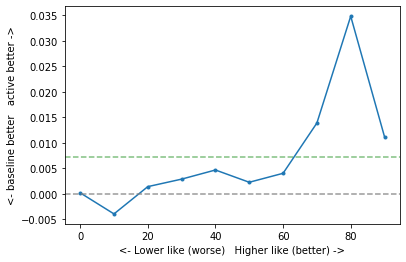

In [244]:
results = []
mean_like = (active_like_reduced[batch_slice, question_n] + baseline_like_reduced[batch_slice, question_n]) / 2
delta_like = active_like_reduced[batch_slice, question_n] - baseline_like_reduced[batch_slice, question_n]
bin_width = 10
for min_pc in np.arange(0, 100, bin_width):
    max_pc = min_pc + bin_width
    min_val, max_val = np.percentile(mean_like, min_pc), np.percentile(mean_like, max_pc)
    selection = (mean_like < max_val) & (mean_like >= min_val)
    
    valid_delta = delta_like[selection]
    results.append((min_pc, max_pc, valid_delta.mean()))

x = [r[0] for r in results]
y = [r[2] for r in results]
plt.plot(x, y, marker='.')
plt.xlabel('<- Lower like (worse)   Higher like (better) ->')
plt.ylabel('<- baseline better   active better ->')
plt.axhline(0., color='grey', alpha=.8, linestyle='--')
plt.axhline(np.mean([r[2] for r in results]), color='g', alpha=.5, linestyle='--')

In [ ]:
# feat_votes = active_dfs[0]['smooth-or-featured_featured-or-disk']
# limit = feat
plt.scatter(active_dfs[0]['smooth-or-featured_featured-or-disk'], mean_loss, alpha=.02, s=10)
plt.xlim(0, 50)
plt.ylim(0, 4)
plt.xlabel('Featured/spiral total votes')
plt.ylabel('Spiral loss')

In [ ]:
# feat_votes = active_dfs[0]['smooth-or-featured_featured-or-disk']
# limit = feat
g = sns.jointplot(active_dfs[0]['smooth-or-featured_featured-or-disk'], mean_loss, kind='hex')
g.ax_marg_x.set_xlim(0, 50)
g.ax_marg_y.set_ylim(0, 4)

In [ ]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            ax = plt.subplot(gs1[row_n, col_n])
            if os.path.isfile(galaxy['local_png_loc']):
                image = Image.open(galaxy['local_png_loc'])
                ax.imshow(image)
    #             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
    #             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
    #             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            else:
                print('Failed to find ', galaxy['local_png_loc'])
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


In [ ]:
# active_df_with_pics = pd.merge(active_dfs[0], catalog['', how='left', on='id_str')

In [ ]:
# active_df_with_pics.columns.values

In [ ]:

min_pc = 0
max_pc = 10
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 20
max_pc = 30
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 80
max_pc = 90
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:

min_pc = 90
max_pc = 100
min_val, max_val = np.percentile(mean_loss, min_pc), np.percentile(mean_loss, max_pc)
selection = (mean_loss < max_val) & (mean_loss >= min_val)



_ = show_galaxies(active_dfs[0][selection])

In [ ]:
question_n

In [ ]:
limits = (0., 8.)
plt.hist(active_losses[:, question_n], bins=30, alpha=.5, range=limits, label='active')
plt.hist(baseline_losses[:, question_n], bins=30, alpha=.5, range=limits, label='baseline')
plt.legend()

In [ ]:
active_losses[:, question_n].mean(), baseline_losses[:, question_n].mean()

In [ ]:
limits = (0., 8.)
plt.hist(np.exp(active_losses[:, question_n]), bins=30, alpha=.5, range=limits, label='active')
plt.hist(np.exp(baseline_losses[:, question_n]), bins=30, alpha=.5, range=limits, label='baseline')
plt.legend()

In [ ]:
active_like

In [ ]:
total_votes = labels[:, :3].sum(axis=1)
retired_selection = total_votes > 36
retired_selection.mean()

In [ ]:
plt.hist(total_votes, bins=30)

In [ ]:
schema.questions

In [ ]:
question_n = 2
bins = 30
plt.hist(active_like[:, question_n], bins=bins, alpha=.5, label='active')
plt.hist(baseline_like[:, question_n], bins=bins, alpha=.5, label='baseline')
plt.legend()

In [ ]:

active_like.mean(axis=0), baseline_like.mean(axis=0)

In [ ]:

active_like.mean(axis=0) - baseline_like.mean(axis=0)

In [ ]:
active_like[:, question_n].mean(), baseline_like[:, question_n].mean()

In [ ]:
np.product(active_like[:, question_n]), np.product(baseline_like[:, question_n])

In [ ]:
low, high = 10 ** 3, .9
bins = np.logspace(np.log10(low),np.log10(high), 50)
plt.hist(active_like[:, question_n]), bins=bins, alpha=.5, label='active')
plt.hist(baseline_like[:, question_n]), bins=bins, alpha=.5, label='baseline')
plt.gca().set_xscale("log")
plt.legend()

In [ ]:
np.exp(active_losses[:, question_n]).mean(), np.exp(baseline_losses[:, question_n]).mean()